this is for all the awards

1. synth timeseries - done
2. synth tpfs via convolution on subpixel - done
3. fit with gaussian only on the first frame - done
4. fit with zernikes only on the first frame
5. look at coherence


In [425]:
import eleanor
import numpy as np
import lightkurve as lk
from matplotlib import pyplot as plt
import tqdm
import scipy.optimize as sopt
from scipy.special import iv
from scipy.signal import convolve2d
from skimage.transform import rescale
from zernike import RZern, FitZern
import torch
from torch.autograd import grad as tgrad
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [426]:
star = eleanor.Source(tic=120362128, sector=14, tc=True)
prf = eleanor.prf.make_prf_from_source(star)

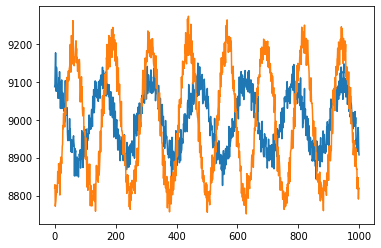

In [428]:
# make some synth data
# i want it to be a transit later so that I can get a CDPP
# but just for method validation let's use a sine wave
amps = 100 * np.array([1, 2])
freqs = np.array([0.04, 0.05])
phis = np.pi * np.array([1, 3]) / 2
t = np.arange(0, 1000)
lc = 9000 + np.vstack((a * np.sin(f * t + p) for a, f, p in zip(amps, freqs, phis)))
lc_m = lc + np.random.normal(0, 25, lc.shape)
plt.plot(t, lc_m.T)

In [511]:
xc, yc = [6.1, 8.2], [6.8, 8.1]
tpfs_up = np.zeros((len(lc_m.T), 99, 99))

base_tpfs = [np.zeros((99,99)) for _ in range(len(xc))] # 11x11 pixels times 9 subpixels
for (xc_v, yc_v, base_v, fl) in zip(xc, yc, base_tpfs, lc_m):
    xl, xu = int(np.floor(xc_v * 9)), int(np.ceil(xc_v * 9)) 
    yl, yu = int(np.floor(yc_v * 9)), int(np.ceil(yc_v * 9))
    for (x, y) in [(xl, yl), (xu, yl), (xl, yu), (xu, yu)]:
        base_v[x, y] += (1 - abs(x - 9 * xc_v)) * (1 - abs(y - 9 * yc_v))
    base_v = convolve2d(base_v, prf)[58:-58, 58:-58]
    base_up = np.array([base_v * f for f in fl])
    tpfs_up += base_up


In [512]:
tpfs = 160 + np.array([rescale(tpf_up.T, 1/9) for tpf_up in tpfs_up])
errs = 25 * np.ones_like(tpfs)

In [513]:
tpfs_t, errs_t = torch.tensor(tpfs), torch.tensor(errs)

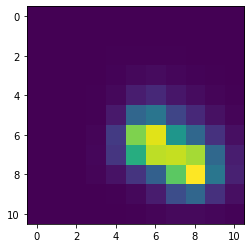

In [514]:
plt.imshow(tpfs_t[900])

In [515]:
nll = lambda mean_val, i: torch.sum(torch.div((mean_val - tpfs_t[i]) ** 2, errs_t[i]))

In [516]:
model = eleanor.models.Gaussian(
            shape=tpfs.shape[1:], 
            col_ref=0, 
            row_ref=0,
            xc = xc,
            yc = yc,
            bkg0 = 90,
            loss = nll
        )

nstars = len(xc)
pars = model.get_default_par(tpfs[0])
num_psf_pars = len(model.get_default_optpars())
fout = np.zeros((len(tpfs), nstars))
bkgout = np.zeros(len(tpfs))
llout = np.zeros(len(tpfs))
parsout = np.zeros((len(tpfs), num_psf_pars))

def loss_and_grad_fn(params, i):
    params = torch.tensor(params, requires_grad=True)
    fluxes = params[:nstars]
    xshift, yshift, bkg = params[nstars:nstars+3]
    optpars = params[nstars+3:]
    mean_val = model.mean(fluxes, xshift, yshift, bkg, optpars)
    loss = nll(mean_val, i)
    gradient = torch.autograd.grad(loss, params)
    return loss.detach().numpy(), gradient[0].detach().numpy()

In [517]:
pars

array([1.56741061e+03, 1.56741061e+03, 0.00000000e+00, 0.00000000e+00,
       9.00000000e+01, 1.00000000e+00, 0.00000000e+00, 1.00000000e+00])

In [518]:
loss_and_grad_fn(pars, 0)

(array(487398.17678423),
 array([-7.19012178e+01, -5.30543850e+01,  2.74269759e+04,  5.99697941e+04,
        -1.83335539e+03, -1.17883486e+04,  2.50824768e+04, -1.94105911e+04]))

In [520]:
for i in tqdm.trange(10):
    res = sopt.minimize(loss_and_grad_fn, pars, i, jac=True, method='TNC', tol=1e-4)
    pars = res.x

print(res)

100%|██████████| 10/10 [00:00<00:00, 21.83it/s]     fun: array(2413.28351378)
     jac: array([-1.85405450e-05, -1.11451129e-04,  5.18432289e-03,  3.30498404e-02,
        8.31657070e-03,  1.01761461e+00,  4.77146436e-01, -3.44514771e-01])
 message: 'Converged (|x_n-x_(n-1)| ~= 0)'
    nfev: 13
     nit: 3
  status: 2
 success: True
       x: array([ 8.22542285e+03,  8.19835105e+03, -4.30928225e-01, -5.25770668e-01,
        1.69600074e+02,  6.06320947e-01, -3.10266327e-03,  5.50086251e-01])



In [521]:
prf_pars = np.array([ 1.32345295e-01, -2.64309959e-03, -1.87840080e-03, -4.65669288e-02, 5.62057525e-03, -4.09518654e-03, -1.86680846e-04, 1.28241834e-03, 1.11773300e-04, 7.87455055e-04, 5.40537843e-03, 1.51009769e-03, -1.38667853e-03,  5.29446498e-04, -5.14992295e-04])

In [522]:
import eleanor
#xc, yc = np.array([4.51646021, 4.3177313 , 4.10392764]), np.array([6.52438976, 2.51141035, 3.87952034])
zmodel = eleanor.models.Zernike(
    shape=tpfs.shape[1:], 
    col_ref=0, 
    row_ref=0, 
    xc = xc,
    yc = yc,
    bkg0 = 90,
    loss = nll,
    source = star,
    zern_n=6
)

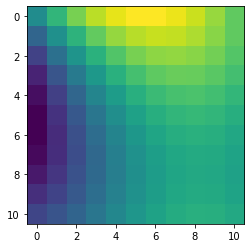

In [523]:
plt.imshow(zmodel(1, 0, 0, np.concatenate(([0.0], prf_pars)), 1))

In [524]:
nstars = 2
pars = model.get_default_par(tpfs[0])
num_psf_pars = len(model.get_default_optpars())
fout = np.zeros((len(tpfs), nstars))
bkgout = np.zeros(len(tpfs))
llout = np.zeros(len(tpfs))
parsout = np.zeros((len(tpfs), num_psf_pars))

def loss_and_grad_fn(params, i):
    params = torch.tensor(params, requires_grad=True)
    fluxes = params[:nstars]
    xshift, yshift, bkg = params[nstars:nstars+3]
    optpars = params[nstars+3:]
    mean_val = zmodel.mean(fluxes, xshift, yshift, bkg, optpars)
    loss = nll(mean_val, i)
    gradient = torch.autograd.grad(loss, params)
    return loss.detach().numpy(), gradient[0].detach().numpy()

In [525]:
p0 = zmodel.get_default_par(np.max(tpfs[0]))

In [526]:
p0

array([ 1.56741061e+03,  1.56741061e+03,  0.00000000e+00,  0.00000000e+00,
        9.00000000e+01,  1.00000000e+00,  6.36197056e+01, -1.42812708e-01,
       -2.66333699e+00, -1.37568201e+01,  9.51680234e-01, -1.65941355e+00,
       -3.29841194e+00,  2.99166996e+00, -1.29923899e-01,  2.61726247e-01,
        4.39909474e+01,  1.21712479e+00, -7.55255184e+00, -1.48054996e+01,
       -9.22375518e-01,  5.92311972e+00, -7.75806368e+00, -2.47553420e+00,
       -1.30486606e+00, -1.91460604e+00,  2.48722242e+00,  1.14541435e+02,
       -1.98976002e+01, -7.13787717e-01, -8.07003559e-01, -6.53388902e+01,
        3.49391393e+00, -2.11774005e-01])

In [527]:
loss_and_grad_fn(p0, 0)

(array(487543.973142),
 array([-7.18572976e+01, -5.28871528e+01,  2.54651249e+04,  6.20183965e+04,
        -1.83335539e+03, -3.08274639e+04, -2.50123984e+00, -2.90072497e+01,
        -1.92981951e+02,  1.58617310e+01, -7.21945408e+01,  7.32391720e+01,
        -2.50964790e+00,  1.19408659e+00,  1.94938978e+02, -6.17796678e+00,
         9.80525013e-01,  1.34102959e+00, -1.54655668e+00,  4.80315345e-02,
         3.18319879e+00,  1.29953891e-01, -6.50066037e-02, -9.84460761e-02,
         1.70143930e-01, -1.64371278e-01,  1.33372463e-03,  7.65096781e-02,
        -5.56050503e-02,  4.58796851e-02,  4.22528687e-02, -5.68386193e-03,
        -1.33131152e-02, -4.43035476e-02]))

In [528]:
rz = RZern(6)
rz.make_cart_grid(*np.meshgrid(np.linspace(-1, 1, 27), np.linspace(-1, 1, 27)), unit_circle=False)
x, res, rank, sv = np.linalg.lstsq(rz.ZZ, zmodel.prf[45:72,45:72].ravel() )

In [529]:
pars = p0
lc_z = np.zeros(1000)
for i in tqdm.trange(10):
    res = sopt.minimize(loss_and_grad_fn, pars, i, jac=True, method='TNC', tol=1e-4)
    pars = res.x
    lc_z[i] = pars[0]

100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


In [530]:
pars

array([ 9.15939570e+03,  8.01480219e+03, -3.70886951e-01, -6.83236374e-01,
        1.63397269e+02,  5.83472610e-01,  1.29952587e+00,  1.31787937e-01,
       -8.79533701e-01, -2.08358412e+00,  8.29290528e-01,  7.76445511e-03,
        6.39960429e-02, -4.56041547e+00, -5.55925629e-02, -2.01089718e-01,
        8.35650927e+01, -1.16908608e+00,  6.68805709e+00,  4.49653491e+00,
       -2.78522479e-01, -9.64319949e+01, -1.60185792e+02, -9.17530563e-01,
       -4.95426645e-01, -6.67401459e+00,  8.23767470e-02,  2.73168403e+02,
        5.83859064e+01, -1.71095565e+00,  1.74186200e+00, -1.45148727e+01,
        1.00910088e+01, -3.76799781e+00])

In [531]:
res

     fun: array(239.03872156)
     jac: array([-1.03178483e-05, -2.33893701e-05, -1.88022132e-01, -2.89361128e-01,
       -9.13968349e-04,  5.09047492e-01,  4.88307924e-02,  1.27930080e-01,
        1.08409816e-01, -2.85630447e-02,  1.56697728e-01, -9.62208796e-01,
        9.30777948e-03,  2.97477977e-02,  1.43536759e+00,  1.24540533e-01,
        9.34440589e-04, -2.77697442e-02,  1.37775056e-02,  2.05448910e-02,
       -1.68396427e-01,  3.46564045e-03, -4.46518591e-04,  1.52649742e-03,
        2.68362629e-02,  7.70415700e-03,  3.70029391e-04, -9.59254789e-05,
        1.57213491e-03,  7.33230953e-04, -1.33466273e-02,  9.73274725e-04,
        2.00850416e-03, -3.31756776e-03])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 99
     nit: 11
  status: 1
 success: True
       x: array([ 9.15939570e+03,  8.01480219e+03, -3.70886951e-01, -6.83236374e-01,
        1.63397269e+02,  5.83472610e-01,  1.29952587e+00,  1.31787937e-01,
       -8.79533701e-01, -2.08358412e+00,  8.29290528e-01,  7.7

In [532]:
lc_m[:,9]

array([9089.07789845, 8821.51217508])

In [413]:
star = eleanor.Source(tic=120362128, sector=14, tc=True)
star.premade = False
sc = lk.search_targetpixelfile(target='tic120362128', sector=14).download()
sq = sc.quality < 5000
start = 2500
end = 3400
time = sc.time[sq][start:end].value
true_tpfs = torch.tensor(sc.flux[sq][start:end].astype(np.float32).value)

In [414]:
nll = lambda mean_val, i: torch.sum(torch.div((mean_val - true_tpfs[i]) ** 2, torch.tensor(errs_t)[i]))
def loss_and_grad_fn(params, i):
    params = torch.tensor(params, requires_grad=True)
    fluxes = params[:nstars]
    xshift, yshift, bkg = params[nstars:nstars+3]
    optpars = params[nstars+3:]
    mean_val = zmodel.mean(fluxes, xshift, yshift, bkg, optpars)
    loss = nll(mean_val, i)
    gradient = torch.autograd.grad(loss, params)
    return loss.detach().numpy(), gradient[0].detach().numpy()

In [416]:
sopt.minimize(loss_and_grad_fn, p0, 100, jac=True, method='TNC', tol=1e-4)

     fun: array(21265863.87635747)
     jac: array([ 3.92494266e+01, -3.81091381e+05, -1.16955152e+06,  1.06762627e+03,
        5.11817840e+07,  1.40453592e+08,  1.14300077e+08, -4.40546287e+04,
       -1.15055764e+04, -1.36692696e+05, -5.12737339e+04, -1.01031549e+05,
       -1.18997308e+05, -8.47806960e+04, -1.08430107e+05, -3.81395474e+05,
       -1.74649652e+05, -8.09259811e+04, -5.18423673e+04, -1.03430234e+05,
       -1.01630920e+05,  1.47599642e+05])
 message: 'Converged (|x_n-x_(n-1)| ~= 0)'
    nfev: 215
     nit: 24
  status: 2
 success: True
       x: array([ 5.77221804e+03,  1.57271975e+00,  1.01475542e+00,  1.14285457e+03,
        2.39274159e-01, -1.50454955e-01,  6.84729644e-02,  5.06394645e+01,
       -1.21379890e+00,  2.56097730e+00, -3.95893629e+01,  1.13777337e+00,
        3.78079847e+00, -3.32584698e+00,  1.86895659e+00, -9.82978613e-01,
       -1.08791228e+00, -8.46685807e+01,  5.74550050e-01,  3.75098885e+00,
        2.33183375e+00,  5.54238457e-01])